In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.image_analysis import *
from core.utils.basic_functions import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import mat73
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
from torchvision import transforms
import matplotlib.image as mpimg
from PIL import Image
from scipy import stats
from torchvision.utils import make_grid



In [2]:
# let set path to the data
data_root = r"N:\PonceLab\Stimuli\Similarity-stress-tests"

In [3]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

In [4]:
# let run the noie test
orinal_img_path = os.path.join(data_root, r'Test-Pixel-Shuffling\original')
shuffled_img_path = os.path.join(data_root, r'Test-Pixel-Shuffling\original-and-shuffled')
# let load the images 
# geting all the images in the folders
original_images = os.listdir(orinal_img_path)
shuffled_images = os.listdir(shuffled_img_path)

# let remove all the non image files
# set the allowed image extensions
allowed_img_extensions = ['jpg', 'jpeg', 'png', 'bmp', 'tiff', 'gif', 'webp', 'tga']
# let filter the images
original_images = [img for img in original_images if img.split('.')[-1].lower() in allowed_img_extensions]
original_images = np.array(original_images)
shuffled_images = [img for img in shuffled_images if img.split('.')[-1].lower() in allowed_img_extensions]
# remove orignal images from the shuffled images
shuffled_images = [img for img in shuffled_images if img not in original_images]

# let sort the images in the shuffled images base of the number in the name before the file extension and after the last underscore if there is any other 
shuffled_images = sorted(shuffled_images, key=lambda x: int(re.findall(r'_(\d+)\.', x)[0]))
shuffled_images = np.array(shuffled_images)

original_images_tensor = torch.stack([preprocess((Image.open(os.path.join(orinal_img_path, img)).convert('RGB'))) for img in original_images])
shuffled_images_tensor = torch.stack([preprocess((Image.open(os.path.join(shuffled_img_path, img)).convert('RGB'))) for img in shuffled_images])


# noise leve is the number we sort the images based on
noise_level = [int(re.findall(r'_(\d+)\.', x)[0]) for x in shuffled_images]
noise_level = np.array(noise_level)


In [5]:
import warnings
warnings.filterwarnings("ignore")
slice = 'center'
from core.utils.image_similarity import TorchImageDistance
import numpy as np
img_dist_obj = TorchImageDistance()
num_of_nose_lever = 11
# let define a nan matrix to store the results
# Create a NaN matrix with shape (rows, columns)
l2_distance_mat = np.full((original_images_tensor.shape[0], num_of_nose_lever), np.nan)
lpips_distance_mat = np.full((original_images_tensor.shape[0], num_of_nose_lever), np.nan)
CNN_cosine_dist_val_mat = np.full((original_images_tensor.shape[0], num_of_nose_lever), np.nan)
CNN_cosine_dist_mat_l1 = np.full((original_images_tensor.shape[0], num_of_nose_lever), np.nan)
CNN_cosine_dist_mat_l2 = np.full((original_images_tensor.shape[0], num_of_nose_lever), np.nan)
CNN_cosine_dist_mat_l3 = np.full((original_images_tensor.shape[0], num_of_nose_lever), np.nan)
CNN_cosine_dist_mat_l4 = np.full((original_images_tensor.shape[0], num_of_nose_lever), np.nan)


for ii in range(original_images_tensor.shape[0]):

    img_org = original_images_tensor[ii]
    img_org_name = original_images[ii] 
    img_org_name = f"{img_org_name.split('.')[0]}_"
    # set a filter on shuffle images for the image_name that contin the img_org_name
    shuffled_images_filter = np.array([len(re.findall(rf'^{img_org_name}(\d+)\.', s))>0 for s in shuffled_images])
    shuffled_images_tensor_filtered = shuffled_images_tensor[shuffled_images_filter]
    shuffled_images_name_filter = shuffled_images[np.where(shuffled_images_filter)[0]]
    if not ((len(shuffled_images_name_filter) == 11)):
        continue
    
    original_images_tensor_filtered = original_images_tensor[ii].unsqueeze(0).repeat(shuffled_images_tensor_filtered.shape[0], 1, 1, 1)
    img_dist_obj.set_first_image_batch(original_images_tensor_filtered)
    img_dist_obj.set_second_image_batch(shuffled_images_tensor_filtered)

    l2_distance, _ = img_dist_obj.get_L2_distance()
    lpips_distance = img_dist_obj.get_LPIPS_distance()
    CNN_cosine_dist,CNN_cosine_dist_mat = img_dist_obj.get_CCN_distance(units_slice=slice)
    CNN_cosine_dist_ly = np.mean(CNN_cosine_dist_mat, axis=(0))
    CNN_cosine_dist_l1 = CNN_cosine_dist_ly[0]
    CNN_cosine_dist_l2 = CNN_cosine_dist_ly[1]
    CNN_cosine_dist_l3 = CNN_cosine_dist_ly[2]
    CNN_cosine_dist_l4 = CNN_cosine_dist_ly[3]

    l2_distance_mat[ii, :] = l2_distance
    lpips_distance_mat[ii, :] = lpips_distance
    CNN_cosine_dist_val_mat[ii, :] = CNN_cosine_dist    
    CNN_cosine_dist_mat_l1[ii, :] = CNN_cosine_dist_l1
    CNN_cosine_dist_mat_l2[ii, :] = CNN_cosine_dist_l2
    CNN_cosine_dist_mat_l3[ii, :] = CNN_cosine_dist_l3
    CNN_cosine_dist_mat_l4[ii, :] = CNN_cosine_dist_l4
noise_level = shuffled_images[np.where(shuffled_images_filter)[0]]


img_dist_obj.memory_cleanup()



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
use the default resnet50 weights
Layer .layer1.2.BatchNorm2dbn3 center units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 center units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 center units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 center units from feature tensor of shape (2048, 8, 8)
Layer .layer1.2.BatchNorm2dbn3 center units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 center units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 center units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 center units from feature tensor of shape (2048, 8, 8)
Layer .V1.BatchNorm2dnorm2 center units from feature tensor of shape (64, 57, 57)
Lay

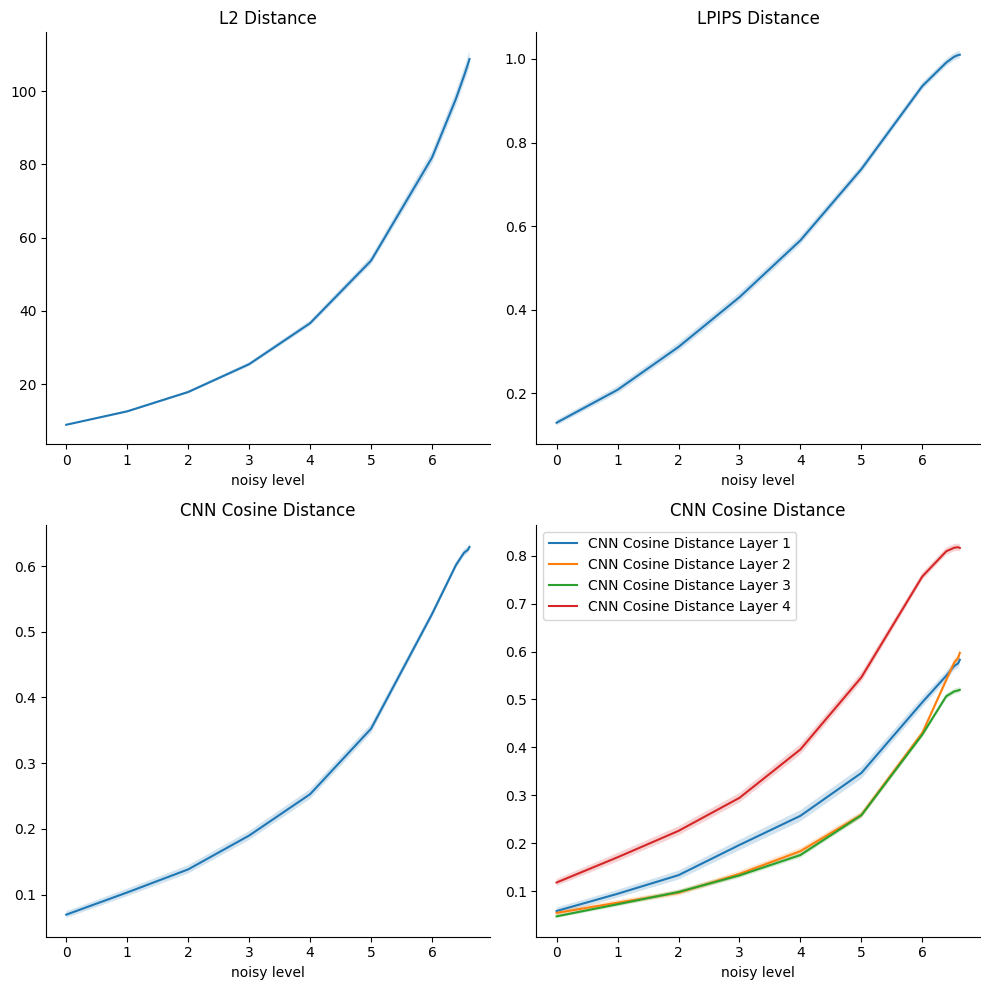

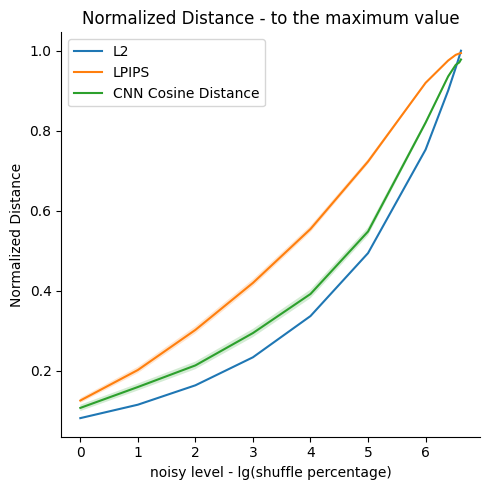

In [25]:
# let plot the results
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# plit line with SEM shaded
l2_distance = np.nanmean(l2_distance_mat, axis=0)
lt_distance_std = stats.sem(l2_distance_mat, axis=0, nan_policy='omit')
ax[0,0].plot(np.log2(noise_level), l2_distance, label='L2')
ax[0,0].fill_between(np.log2(noise_level), l2_distance - lt_distance_std, l2_distance + lt_distance_std, alpha=0.2)
ax[0,0].set_title('L2 Distance')
ax[0,0].set_xlabel('noisy level')

lpips_distance = np.nanmean(lpips_distance_mat, axis=0)
lpips_distance_std = stats.sem(lpips_distance_mat, axis=0, nan_policy='omit')
ax[0,1].plot(np.log2(noise_level), lpips_distance, label='LPIPS')
ax[0,1].fill_between(np.log2(noise_level), lpips_distance - lpips_distance_std, lpips_distance + lpips_distance_std, alpha=0.2)
ax[0, 1].set_title('LPIPS Distance')
ax[0, 1].set_xlabel('noisy level')

CNN_cosine_dist = np.nanmean(CNN_cosine_dist_val_mat, axis=0)
CNN_cosine_dist_std = stats.sem(CNN_cosine_dist_val_mat, axis=0, nan_policy='omit')
ax[1, 0].plot(np.log2(noise_level), CNN_cosine_dist, label='CNN Cosine Distance')
ax[1, 0].fill_between(np.log2(noise_level), CNN_cosine_dist - CNN_cosine_dist_std, CNN_cosine_dist + CNN_cosine_dist_std, alpha=0.2)
ax[1, 0].set_title('CNN Cosine Distance')
ax[1, 0].set_xlabel('noisy level')

CNN_cosine_dist_l1 = np.nanmean(CNN_cosine_dist_mat_l1, axis=0)
CNN_cosine_dist_l1_std = stats.sem(CNN_cosine_dist_mat_l1, axis=0, nan_policy='omit')
CNN_cosine_dist_l2 = np.nanmean(CNN_cosine_dist_mat_l2, axis=0)
CNN_cosine_dist_l2_std = stats.sem(CNN_cosine_dist_mat_l2, axis=0, nan_policy='omit')
CNN_cosine_dist_l3 = np.nanmean(CNN_cosine_dist_mat_l3, axis=0)
CNN_cosine_dist_l3_std = stats.sem(CNN_cosine_dist_mat_l3, axis=0, nan_policy='omit')
CNN_cosine_dist_l4 = np.nanmean(CNN_cosine_dist_mat_l4, axis=0)
CNN_cosine_dist_l4_std = stats.sem(CNN_cosine_dist_mat_l4, axis=0, nan_policy='omit')
ax[1, 1].plot(np.log2(noise_level), CNN_cosine_dist_l1, label='CNN Cosine Distance Layer 1')
ax[1, 1].fill_between(np.log2(noise_level), CNN_cosine_dist_l1 - CNN_cosine_dist_l1_std, CNN_cosine_dist_l1 + CNN_cosine_dist_l1_std, alpha=0.2)
ax[1, 1].plot(np.log2(noise_level), CNN_cosine_dist_l2, label='CNN Cosine Distance Layer 2')
ax[1, 1].fill_between(np.log2(noise_level), CNN_cosine_dist_l2 - CNN_cosine_dist_l2_std, CNN_cosine_dist_l2 + CNN_cosine_dist_l2_std, alpha=0.2)
ax[1, 1].plot(np.log2(noise_level), CNN_cosine_dist_l3, label='CNN Cosine Distance Layer 3')
ax[1, 1].fill_between(np.log2(noise_level), CNN_cosine_dist_l3 - CNN_cosine_dist_l3_std, CNN_cosine_dist_l3 + CNN_cosine_dist_l3_std, alpha=0.2)
ax[1, 1].plot(np.log2(noise_level), CNN_cosine_dist_l4, label='CNN Cosine Distance Layer 4')
ax[1, 1].fill_between(np.log2(noise_level), CNN_cosine_dist_l4 - CNN_cosine_dist_l4_std, CNN_cosine_dist_l4 + CNN_cosine_dist_l4_std, alpha=0.2)
ax[1, 1].set_title('CNN Cosine Distance')
ax[1, 1].set_xlabel('noisy level')
# add legend
ax[1, 1].legend()

plt.tight_layout()
plt.show()

# let normalize the distances mat row by max value of the row
l2_distance_mat_norm = l2_distance_mat / np.nanmax(l2_distance_mat, axis=1)[:, None]
lpips_distance_mat_norm = lpips_distance_mat / np.nanmax(lpips_distance_mat, axis=1)[:, None]
CNN_cosine_dist_mat_norm = CNN_cosine_dist_val_mat / np.nanmax(CNN_cosine_dist_val_mat, axis=1)[:, None]

l2_distance_norm = np.nanmean(l2_distance_mat_norm, axis=0)
lt_distance_std = stats.sem(l2_distance_mat_norm, axis=0, nan_policy='omit')
lpips_distance_norm = np.nanmean(lpips_distance_mat_norm, axis=0)
lpips_distance_std = stats.sem(lpips_distance_mat_norm, axis=0, nan_policy='omit')
CNN_cosine_dist_norm = np.nanmean(CNN_cosine_dist_mat_norm, axis=0)
CNN_cosine_dist_std = stats.sem(CNN_cosine_dist_mat_norm, axis=0, nan_policy='omit')

# let plot the results with STD shaded
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.log2(noise_level), l2_distance_norm, label='L2')
ax.fill_between(np.log2(noise_level), l2_distance_norm - lt_distance_std, l2_distance_norm + lt_distance_std, alpha=0.2)
ax.plot(np.log2(noise_level), lpips_distance_norm, label='LPIPS')
ax.fill_between(np.log2(noise_level), lpips_distance_norm - lpips_distance_std, lpips_distance_norm + lpips_distance_std, alpha=0.2)
ax.plot(np.log2(noise_level), CNN_cosine_dist_norm, label='CNN Cosine Distance')
ax.fill_between(np.log2(noise_level), CNN_cosine_dist_norm - CNN_cosine_dist_std, CNN_cosine_dist_norm + CNN_cosine_dist_std, alpha=0.2)
ax.set_title('Normalized Distance - to the maximum value')
ax.set_xlabel('noisy level - lg(shuffle percentage)')
ax.set_ylabel('Normalized Distance')
ax.legend()
plt.tight_layout()
plt.show()


In [26]:
# let read the Test-GAN-Styles data 
# let set a 
gan_styles_path = os.path.join(data_root, r'Test-GAN-Styles')
# let load the images
gan_styles_images = os.listdir(gan_styles_path)
# let filter the images
gan_styles_images = [img for img in gan_styles_images if img.split('.')[-1].lower() in allowed_img_extensions]
# let read the images and convert them to tensor
gan_styles_images_tensor = torch.stack([preprocess((Image.open(os.path.join(gan_styles_path, img)).convert('RGB'))) for img in gan_styles_images])

In [27]:
# let find distance of each image with all others
l2_distance_gan_styles = list()
lpips_distance_gan_styles = list()
CNN_cosine_dist_gan_styles = list()
CNN_cosine_dist_gan_styles_l1 = list()
CNN_cosine_dist_gan_styles_l2 = list()
CNN_cosine_dist_gan_styles_l3 = list()
CNN_cosine_dist_gan_styles_l4 = list()

img_dist_obj = TorchImageDistance()
img_dist_obj.set_first_image_batch(gan_styles_images_tensor)
slice = 'center'

for i in range(gan_styles_images_tensor.shape[0]):
    img = gan_styles_images_tensor[i]
    img_dist_obj.set_second_image_batch(img.repeat(gan_styles_images_tensor.shape[0], 1, 1, 1))
    l2_distance, _ = img_dist_obj.get_L2_distance()
    lpips_distance = img_dist_obj.get_LPIPS_distance()
    CNN_cosine_dist,CNN_cosine_dist_mat = img_dist_obj.get_CCN_distance(units_slice=slice)
    CNN_cosine_dist_ly = np.mean(CNN_cosine_dist_mat, axis=(0))
    CNN_cosine_dist_l1 = CNN_cosine_dist_ly[0]
    CNN_cosine_dist_l2 = CNN_cosine_dist_ly[1]
    CNN_cosine_dist_l3 = CNN_cosine_dist_ly[2]
    CNN_cosine_dist_l4 = CNN_cosine_dist_ly[3]
    l2_distance_gan_styles.append(l2_distance)
    lpips_distance_gan_styles.append(lpips_distance)
    CNN_cosine_dist_gan_styles.append(CNN_cosine_dist)
    CNN_cosine_dist_gan_styles_l1.append(CNN_cosine_dist_l1)
    CNN_cosine_dist_gan_styles_l2.append(CNN_cosine_dist_l2)
    CNN_cosine_dist_gan_styles_l3.append(CNN_cosine_dist_l3)
    CNN_cosine_dist_gan_styles_l4.append(CNN_cosine_dist_l4)    

img_dist_obj.memory_cleanup()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
use the default resnet50 weights
Layer .layer1.2.BatchNorm2dbn3 center units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 center units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 center units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 center units from feature tensor of shape (2048, 8, 8)
Layer .layer1.2.BatchNorm2dbn3 center units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 center units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 center units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 center units from feature tensor of shape (2048, 8, 8)
Layer .V1.BatchNorm2dnorm2 center units from feature tensor of shape (64, 57, 57)
Lay

In [ ]:
# let devided them to the 3 class one big gan (nabe BigGAN) in their name deepsim (have deepsim in their name) and the rest (which is natural images)
gan_styles_images_class = list()
for img in gan_styles_images:
    if 'BigGAN' in img:
        gan_styles_images_class.append(1)
    elif 'deepsim' in img:
        gan_styles_images_class.append(2)
    else:
        gan_styles_images_class.append(3)
gan_styles_images_class = np.array(gan_styles_images_class)
# let concatenate the distances on the second axis
l2_distance_gan_styles_cat = np.stack(l2_distance_gan_styles, axis=1)
lpips_distance_gan_styles_cat = np.stack(lpips_distance_gan_styles, axis=1)
CNN_cosine_dist_gan_styles_cat = np.stack(CNN_cosine_dist_gan_styles, axis=1)
CNN_cosine_dist_gan_styles_l1_cat = np.stack(CNN_cosine_dist_gan_styles_l1, axis=1)
CNN_cosine_dist_gan_styles_l2_cat = np.stack(CNN_cosine_dist_gan_styles_l2, axis=1)
CNN_cosine_dist_gan_styles_l3_cat = np.stack(CNN_cosine_dist_gan_styles_l3, axis=1)
CNN_cosine_dist_gan_styles_l4_cat = np.stack(CNN_cosine_dist_gan_styles_l4, axis=1)


# let plot the results in imagesec 
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(l2_distance_gan_styles_cat, ax=ax[0, 0])
ax[0, 0].set_title('L2 Distance \n BigGAN, deepsim, Natural')

sns.heatmap(lpips_distance_gan_styles_cat, ax=ax[0, 1])
ax[0, 1].set_title('LPIPS Distance \n BigGAN, deepsim, Natural')

sns.heatmap(CNN_cosine_dist_gan_styles_cat, ax=ax[1, 0])
ax[1, 0].set_title('CNN Cosine Distance \n BigGAN, deepsim, Natural')


for i in range(2):
    for j in range(2):
        ax[i, j].set_aspect('equal')
        # Add bars with diffrent colors n x and x axis to show the class ouside the heatmap
        ax[i, j].axhline(np.where(gan_styles_images_class == 1)[0][-1]+1, color='g', lw=1)
        ax[i, j].axvline( np.where(gan_styles_images_class == 1)[0][-1]+1, color='g', lw=1)

        ax[i, j].axhline(np.where(gan_styles_images_class == 2)[0][-1]+1, color='b', lw=1)
        ax[i, j].axvline( np.where(gan_styles_images_class == 2)[0][-1]+1, color='b', lw=1)
        # remove the axis labels
        ax[i, j].axis('off')





plt.tight_layout()

In [ ]:
# let read all the images in diffrent sub folders of the Test-Categorization
# let read the Test-GAN-Styles data 
# let set a 
test_categorization_path = os.path.join(data_root, r'Test-Categorization')
man_cat_path = os.path.join(test_categorization_path, '0001_man')
monkey_cat_path = os.path.join(test_categorization_path, '0352_monkey')
greenhouse_cat_path = os.path.join(test_categorization_path, '1811_greenhouse')

# let load the images
man_cat_imgs_name = os.listdir(man_cat_path)
monkey_cat_imgs_name = os.listdir(monkey_cat_path)
greenhouse_cat_imgs_name = os.listdir(greenhouse_cat_path)

# let filter the images
man_cat_imgs_name =  [img for img in man_cat_imgs_name if img.split('.')[-1].lower() in allowed_img_extensions]
monkey_cat_imgs_name =  [img for img in monkey_cat_imgs_name if img.split('.')[-1].lower() in allowed_img_extensions]
greenhouse_cat_imgs_name =  [img for img in greenhouse_cat_imgs_name if img.split('.')[-1].lower() in allowed_img_extensions]

# let read the images and convert them to tensor
man_cat_imgs_tensor = torch.stack([preprocess((Image.open(os.path.join(man_cat_path, img)).convert('RGB'))) for img in man_cat_imgs_name])
monkey_cat_imgs_tensor = torch.stack([preprocess((Image.open(os.path.join(monkey_cat_path, img)).convert('RGB'))) for img in monkey_cat_imgs_name])
greenhouse_cat_imgs_tensor = torch.stack([preprocess((Image.open(os.path.join(greenhouse_cat_path, img)).convert('RGB'))) for img in greenhouse_cat_imgs_name])

# let concatenate the images
all_cat_imgs = torch.cat([man_cat_imgs_tensor, monkey_cat_imgs_tensor, greenhouse_cat_imgs_tensor], dim=0)
images_cat_class = np.concatenate([np.ones(len(man_cat_imgs_name)), np.ones(len(monkey_cat_imgs_name))*2, np.ones(len(greenhouse_cat_imgs_name))*3])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
slice = 'center'
from core.utils.image_similarity import TorchImageDistance

# let find distance of each image with all others
l2_distance_gan_styles = list()
lpips_distance_gan_styles = list()
CNN_cosine_dist_gan_styles = list()
CNN_cosine_dist_gan_styles_l1 = list()
CNN_cosine_dist_gan_styles_l2 = list()
CNN_cosine_dist_gan_styles_l3 = list()
CNN_cosine_dist_gan_styles_l4 = list()

img_dist_obj = TorchImageDistance()
img_dist_obj.set_first_image_batch(all_cat_imgs)

for i in range(all_cat_imgs.shape[0]):
    img = all_cat_imgs[i]
    img_dist_obj.set_second_image_batch(img.repeat(all_cat_imgs.shape[0], 1, 1, 1))
    l2_distance, _ = img_dist_obj.get_L2_distance()
    lpips_distance = img_dist_obj.get_LPIPS_distance()
    CNN_cosine_dist,CNN_cosine_dist_mat = img_dist_obj.get_CCN_distance(units_slice=slice)
    CNN_cosine_dist_ly = np.mean(CNN_cosine_dist_mat, axis=(0))
    CNN_cosine_dist_l1 = CNN_cosine_dist_ly[0]
    CNN_cosine_dist_l2 = CNN_cosine_dist_ly[1]
    CNN_cosine_dist_l3 = CNN_cosine_dist_ly[2]
    CNN_cosine_dist_l4 = CNN_cosine_dist_ly[3]
    l2_distance_gan_styles.append(l2_distance)
    lpips_distance_gan_styles.append(lpips_distance)
    CNN_cosine_dist_gan_styles.append(CNN_cosine_dist)
    CNN_cosine_dist_gan_styles_l1.append(CNN_cosine_dist_l1)
    CNN_cosine_dist_gan_styles_l2.append(CNN_cosine_dist_l2)
    CNN_cosine_dist_gan_styles_l3.append(CNN_cosine_dist_l3)
    CNN_cosine_dist_gan_styles_l4.append(CNN_cosine_dist_l4)    

img_dist_obj.memory_cleanup()

In [ ]:
l2_distance_gan_styles_cat = np.stack(l2_distance_gan_styles, axis=1)
lpips_distance_gan_styles_cat = np.stack(lpips_distance_gan_styles, axis=1)
CNN_cosine_dist_gan_styles_cat = np.stack(CNN_cosine_dist_gan_styles, axis=1)
CNN_cosine_dist_gan_styles_l1_cat = np.stack(CNN_cosine_dist_gan_styles_l1, axis=1)
CNN_cosine_dist_gan_styles_l2_cat = np.stack(CNN_cosine_dist_gan_styles_l2, axis=1)
CNN_cosine_dist_gan_styles_l3_cat = np.stack(CNN_cosine_dist_gan_styles_l3, axis=1)
CNN_cosine_dist_gan_styles_l4_cat = np.stack(CNN_cosine_dist_gan_styles_l4, axis=1)


# let plot the results in imagesec 
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(l2_distance_gan_styles_cat, ax=ax[0, 0])
ax[0, 0].set_title('L2 Distance \n man, Monkey, greenhouse')

sns.heatmap(lpips_distance_gan_styles_cat, ax=ax[0, 1])
ax[0, 1].set_title('LPIPS Distance \n man, Monkey, greenhouse')

sns.heatmap(CNN_cosine_dist_gan_styles_cat, ax=ax[1, 0])
ax[1, 0].set_title('CNN Cosine Distance \n man, Monkey, greenhouse')


for i in range(2):
    for j in range(2):
        ax[i, j].set_aspect('equal')
        # Add bars with diffrent colors n x and x axis to show the class ouside the heatmap
        ax[i, j].axhline(np.where(images_cat_class == 1)[0][-1]+1, color='g', lw=1)
        ax[i, j].axvline( np.where(images_cat_class == 1)[0][-1]+1, color='g', lw=1)

        ax[i, j].axhline(np.where(images_cat_class == 2)[0][-1]+1, color='b', lw=1)
        ax[i, j].axvline( np.where(images_cat_class == 2)[0][-1]+1, color='b', lw=1)
        # remove the axis labels
        ax[i, j].axis('off')



In [ ]:
# let plot the results in imagesec 
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(CNN_cosine_dist_gan_styles_l1_cat, ax=ax[0, 0])
ax[0, 0].set_title('CNN Cosine Distance Layer 1 \n Man, Monkey, Greenhouse')

sns.heatmap(CNN_cosine_dist_gan_styles_l2_cat, ax=ax[0, 1])
ax[0, 1].set_title('CNN Cosine Distance Layer 2 \n Man, Monkey, Greenhouse')

sns.heatmap(CNN_cosine_dist_gan_styles_l3_cat, ax=ax[1, 0])
ax[1, 0].set_title('CNN Cosine Distance Layer 3 \n Man, Monkey, Greenhouse')

sns.heatmap(CNN_cosine_dist_gan_styles_l4_cat, ax=ax[1, 1])
ax[1, 1].set_title('CNN Cosine Distance Layer 4 \n Man, Monkey, Greenhouse')

for i in range(2):
    for j in range(2):
        ax[i, j].set_aspect('equal')
        # Add bars with diffrent colors n x and x axis to show the class ouside the heatmap
        ax[i, j].axhline(np.where(images_cat_class == 1)[0][-1]+1, color='g', lw=1)
        ax[i, j].axvline( np.where(images_cat_class == 1)[0][-1]+1, color='g', lw=1)

        ax[i, j].axhline(np.where(images_cat_class == 2)[0][-1]+1, color='b', lw=1)
        ax[i, j].axvline( np.where(images_cat_class == 2)[0][-1]+1, color='b', lw=1)
        # remove the axis labels
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()